# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import MeanShift

from sklearn.ensemble import AdaBoostRegressor # Adaptive Boosting
from sklearn.ensemble import GradientBoostingRegressor # Gradient Tree Boosting



from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score

from scipy import stats
from time import time
# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows',200)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Exploration & Visualization

In [4]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,...,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_5,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1,KBA13_VORB_1_2,KBA13_VORB_2,KBA13_VORB_3,KBA13_VW,KK_KUNDENTYP,KKK,KOMBIALTER,KONSUMNAEHE,KONSUMZELLE,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,MIN_GEBAEUDEJAHR,MOBI_RASTER,MOBI_REGIO,NATIONALITAET_KZ,ONLINE_AFFINITAET,ORTSGR_KLS9,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_GBZ,PLZ8_HHZ,PRAEGENDE_JUGENDJAHRE,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,794213.000000,817722.000000,817722.000000,798073.000000,817722.000000,794005.000000,797481.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,634108.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,634108.000000,891221.000000,891221.000000,891221.000000,634108.000000,891221.000000,891221.000000,891221.000000,634108.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,634108.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,8

In [5]:
azdias_null = azdias.isnull().sum()

In [6]:
azdias_null

LNR                                 0
AGER_TYP                            0
AKT_DAT_KL                      73499
ALTER_HH                        73499
ALTER_KIND1                    810163
ALTER_KIND2                    861722
ALTER_KIND3                    885051
ALTER_KIND4                    890016
ALTERSKATEGORIE_FEIN           262947
ANZ_HAUSHALTE_AKTIV             93148
ANZ_HH_TITEL                    97008
ANZ_KINDER                      73499
ANZ_PERSONEN                    73499
ANZ_STATISTISCHE_HAUSHALTE      93148
ANZ_TITEL                       73499
ARBEIT                          97216
BALLRAUM                        93740
CAMEO_DEU_2015                  98979
CAMEO_DEUG_2015                 98979
CAMEO_INTL_2015                 98979
CJT_GESAMTTYP                    4854
CJT_KATALOGNUTZER                4854
CJT_TYP_1                        4854
CJT_TYP_2                        4854
CJT_TYP_3                        4854
CJT_TYP_4                        4854
CJT_TYP_5   

In [7]:
azdias_null_percent = azdias_null / len(azdias) * 100

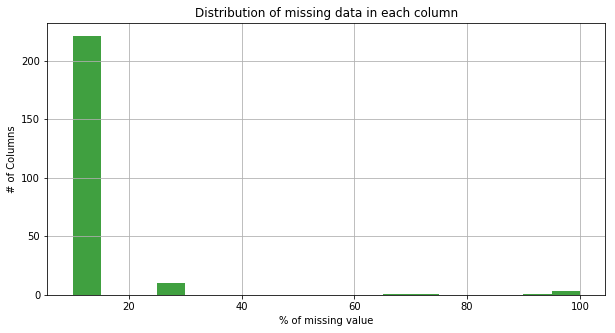

% of missing data in columns 
 ALTER_KIND4                    99.864792
ALTER_KIND3                    99.307691
ALTER_KIND2                    96.690047
ALTER_KIND1                    90.904837
EXTSEL992                      73.399639
KK_KUNDENTYP                   65.596749
ALTERSKATEGORIE_FEIN           29.504130
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_LOTTO                      28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_SOZIALES                   28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
KBA05_MOTOR                    14.959701
KBA05_MOD8                     14.959701
KBA05_MOD4                     14.959701
KBA05_MOD3                     14.959701
KBA05_MOD2                     14.959701
KBA05_SEG1                     14.959701
KBA05_MOD1                     14.959701
KBA05_MAXVORB             

In [8]:
plt.figure(figsize=(10,5))
plt.hist(azdias_null_percent, bins = np.linspace(10,100,19), facecolor='g', alpha=0.75)


plt.xlabel('% of missing value')
plt.ylabel('# of Columns')
plt.title('Distribution of missing data in each column')
plt.grid(True)

plt.show()

# % of missing data in columns
print('% of missing data in columns','\n',azdias_null_percent.sort_values(ascending=False))

In [9]:
sum(azdias.isnull().sum())

33492923

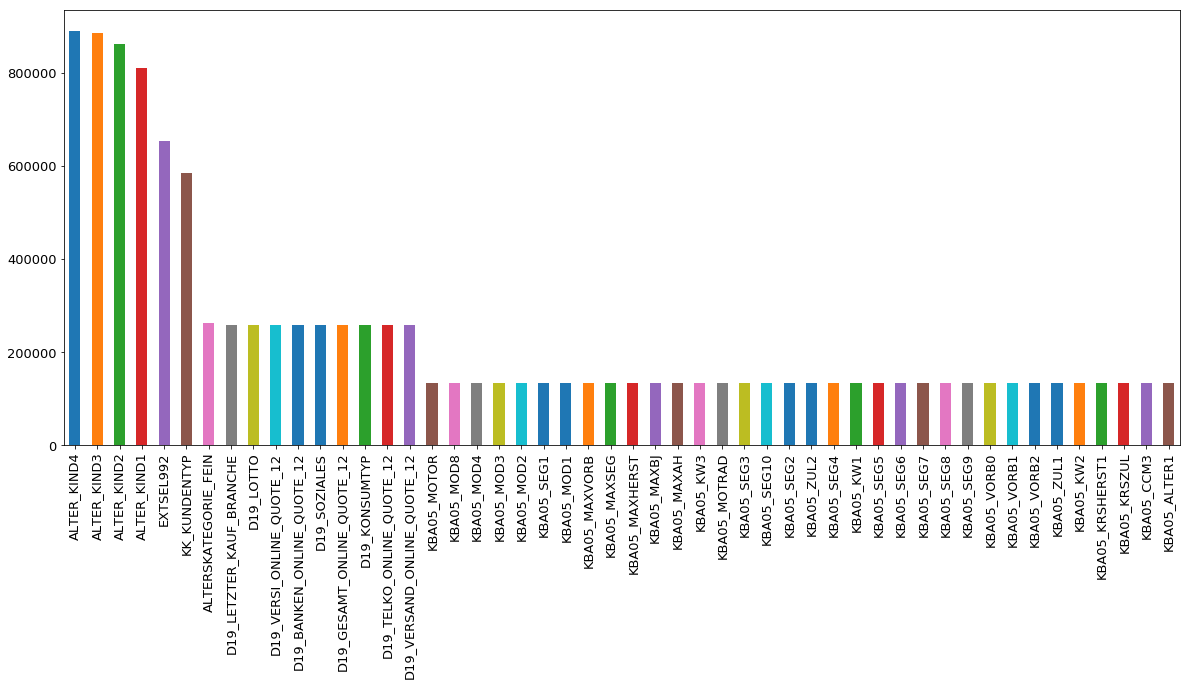

In [10]:
#Visualizing null data
(azdias_null.sort_values(ascending=False)[:50].plot(kind='bar', figsize=(20,8), fontsize=13))

In [11]:
#Percentage of null values in order
round(azdias.isnull().sum()/azdias.shape[0]*100,1).sort_values(ascending=False)


ALTER_KIND4                    99.9
ALTER_KIND3                    99.3
ALTER_KIND2                    96.7
ALTER_KIND1                    90.9
EXTSEL992                      73.4
KK_KUNDENTYP                   65.6
ALTERSKATEGORIE_FEIN           29.5
D19_LETZTER_KAUF_BRANCHE       28.8
D19_LOTTO                      28.8
D19_VERSI_ONLINE_QUOTE_12      28.8
D19_BANKEN_ONLINE_QUOTE_12     28.8
D19_SOZIALES                   28.8
D19_GESAMT_ONLINE_QUOTE_12     28.8
D19_KONSUMTYP                  28.8
D19_TELKO_ONLINE_QUOTE_12      28.8
D19_VERSAND_ONLINE_QUOTE_12    28.8
KBA05_MOTOR                    15.0
KBA05_MOD8                     15.0
KBA05_MOD4                     15.0
KBA05_MOD3                     15.0
KBA05_MOD2                     15.0
KBA05_SEG1                     15.0
KBA05_MOD1                     15.0
KBA05_MAXVORB                  15.0
KBA05_MAXSEG                   15.0
KBA05_MAXHERST                 15.0
KBA05_MAXBJ                    15.0
KBA05_MAXAH                 

Text(0.5,0,'prop. of missing values')

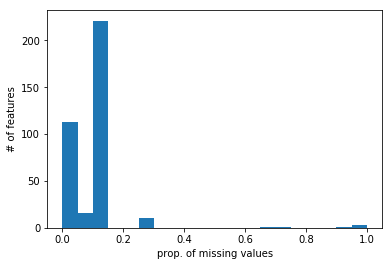

In [12]:
# above we have already identified %  of nan/null values columnwise
# let's visualise the distribution trend 
column_nans = azdias.isnull().mean()

plt.hist(column_nans, bins = np.arange(0,1+.05,.05))
plt.ylabel('# of features')
plt.xlabel('prop. of missing values')


In [13]:
print("Percentage of data kept:",round(azdias.isnull().sum(axis=1).value_counts().sort_index().cumsum()[:30]/azdias.isnull().sum(axis=1).shape[0]*100,0))

Percentage of data kept: 0      0.0
1      0.0
2      1.0
3      3.0
4     17.0
5     38.0
6     56.0
7     62.0
8     63.0
9     64.0
10    64.0
11    64.0
12    65.0
13    65.0
14    65.0
15    73.0
16    82.0
17    83.0
18    83.0
19    83.0
20    84.0
21    84.0
22    84.0
23    84.0
24    84.0
25    84.0
26    84.0
27    84.0
28    84.0
29    84.0
dtype: float64


In [14]:
azdias.shape

(891221, 366)

## Data preprocessing

In [15]:
azdias = azdias[azdias.isnull().sum(axis=1) <= 16].reset_index(drop=True)
print('number of rows in new dataset: ',azdias.shape[0])

number of rows in new dataset:  733227


In [16]:
drop_cols = azdias.columns[column_nans > 0.65]
print('columns to drop: ', drop_cols)

columns to drop:  Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992',
       'KK_KUNDENTYP'],
      dtype='object')


In [17]:
print('number of rows in new dataset: ',azdias.shape[0])

number of rows in new dataset:  733227


In [18]:
# Before dropping data on azdias lets preprocess customers dataset and get it ready for further processing
# Drop the extra column of customers dataset.

customers.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)

In [19]:
print('# of column in azdias before dropping: ', len(azdias.columns))
azdias = azdias.drop(drop_cols,axis=1)
print('# of column in azdias after dropping: ', len(azdias.columns))

print('# of column in customers before dropping: ', len(customers.columns))
customers = customers.drop(drop_cols,axis=1)
print('# of column in customers after dropping: ', len(customers.columns))

# of column in azdias before dropping:  366
# of column in azdias after dropping:  360
# of column in customers before dropping:  366
# of column in customers after dropping:  360


In [20]:
print('number of rows in new dataset: ',azdias.shape)
print('number of rows in new dataset: ',customers.shape)

number of rows in new dataset:  (733227, 360)
number of rows in new dataset:  (191652, 360)


In [21]:
# object field EINGEFUEGT_AM has too many different items. Dropping from dataset
azdias = azdias.drop(['EINGEFUEGT_AM'],axis=1)
customers = customers.drop(['EINGEFUEGT_AM'],axis=1)

In [22]:
# object field D19_LETZTER_KAUF_BRANCHE has many different items. Dropping from dataset

azdias = azdias.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)
customers = customers.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)

In [23]:
# clean up step - as without this we end up with 406 columns after one-hot encoding
# reduce number of columns further by trying to removing highly correlated columns
# find correlation matrix    
corr_matrix = azdias.corr().abs()
upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# identify columns to drop based on threshold limit
drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
# drop columns from azdias
azdias = azdias.drop(drop_columns, axis=1)
print('number of columns', len(azdias.columns))

# repeat for customers
# find correlation matrix    
corr_matrix = customers.corr().abs()
upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# identify columns to drop based on threshold limit
drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
# drop columns from azdias
customers = customers.drop(drop_columns, axis=1)
print('number of columns', len(customers.columns))

number of columns 238
number of columns 256


In [24]:
print('number of rows in new dataset: ',azdias.shape)
print('number of rows in new dataset: ',customers.shape)

number of rows in new dataset:  (733227, 238)
number of rows in new dataset:  (191652, 256)


In [25]:
azdias.select_dtypes(include=['object']).head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,OST_WEST_KZ
0,8A,8,51,W
1,4C,4,24,W
2,2A,2,12,W
3,6B,6,43,W
4,8C,8,54,W


In [28]:
print('number of columns', len(azdias.columns))

number of columns 238


In [29]:

# before going ahead with encoding we need to find categorical fields - below 1 hack option to do it
cols = azdias.columns
num_cols = azdias._get_numeric_data().columns
print('num_cols: ',num_cols)
print('categorical: ',list(set(cols) - set(num_cols)))

num_cols:  Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_TITEL',
       ...
       'UMFELD_ALT', 'UMFELD_JUNG', 'UNGLEICHENN_FLAG', 'VERDICHTUNGSRAUM',
       'VERS_TYP', 'VHA', 'VHN', 'W_KEIT_KIND_HH', 'WOHNLAGE', 'ZABEOTYP'],
      dtype='object', length=234)
categorical:  ['CAMEO_INTL_2015', 'CAMEO_DEUG_2015', 'OST_WEST_KZ', 'CAMEO_DEU_2015']


In [30]:
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = azdias[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = customers[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
azdias[['CAMEO_DEU_2015','OST_WEST_KZ']]=azdias[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)
customers[['CAMEO_DEU_2015','OST_WEST_KZ']]=customers[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)

In [31]:
customers.isnull().sum()

LNR                                0
AGER_TYP                           0
AKT_DAT_KL                     46596
ALTER_HH                       46596
ALTERSKATEGORIE_FEIN           51842
ANZ_HAUSHALTE_AKTIV            49927
ANZ_HH_TITEL                   52110
ANZ_KINDER                     46596
ANZ_PERSONEN                   46596
ANZ_TITEL                      46596
ARBEIT                         50476
BALLRAUM                       49959
CAMEO_DEU_2015                     0
CAMEO_DEUG_2015                    0
CAMEO_INTL_2015                    0
CJT_GESAMTTYP                   3213
CJT_KATALOGNUTZER               3213
CJT_TYP_1                       3213
CJT_TYP_3                       3213
CJT_TYP_6                       3213
D19_BANKEN_ANZ_12                  0
D19_BANKEN_DIREKT                  0
D19_BANKEN_GROSS                   0
D19_BANKEN_LOKAL                   0
D19_BANKEN_OFFLINE_DATUM           0
D19_BANKEN_REST                    0
D19_BEKLEIDUNG_GEH                 0
D

In [32]:
azdias.isnull().sum()

LNR                                 0
AGER_TYP                            0
AKT_DAT_KL                          0
ALTER_HH                            0
ALTERSKATEGORIE_FEIN           167182
ANZ_HAUSHALTE_AKTIV                 0
ANZ_HH_TITEL                     2783
ANZ_KINDER                          0
ANZ_PERSONEN                        0
ANZ_TITEL                           0
ARBEIT                           2948
BALLRAUM                          418
CAMEO_DEU_2015                      0
CAMEO_DEUG_2015                     0
CAMEO_INTL_2015                     0
CJT_GESAMTTYP                       0
CJT_KATALOGNUTZER                   0
CJT_TYP_1                           0
CJT_TYP_6                           0
D19_BANKEN_ANZ_12                   0
D19_BANKEN_DIREKT                   0
D19_BANKEN_GROSS                    0
D19_BANKEN_LOKAL                    0
D19_BANKEN_OFFLINE_DATUM            0
D19_BANKEN_REST                     0
D19_BEKLEIDUNG_GEH                  0
D19_BEKLEIDU

In [33]:
# fillna with 9 for fields that has 9 marked as unknown
azdias[azdias.columns[(azdias==9).any()]] = azdias[azdias.columns[(azdias==9).any()]].fillna(9)
customers[customers.columns[(customers==9).any()]] = customers[customers.columns[(customers==9).any()]].fillna(9)

In [34]:
# fillna with 0 for fields that has 0 marked as unknown
azdias[azdias.columns[(azdias==0).any()]] = azdias[azdias.columns[(azdias==0).any()]].fillna(0)
customers[customers.columns[(customers==0).any()]] = customers[customers.columns[(customers==0).any()]].fillna(0)

In [35]:
# fillna with -1 for fields that has 0 marked as unknown

azdias[azdias.columns[(azdias==-1).any()]] = azdias[azdias.columns[(azdias==-1).any()]].fillna(-1)
customers[customers.columns[(customers==-1).any()]] = customers[customers.columns[(customers==-1).any()]].fillna(-1)

In [36]:
#with  all null data now handled, we should focus on getting objects/categorical variables to numbers via one hot encoding

azdias = pd.get_dummies(azdias)
customers = pd.get_dummies(customers)

In [37]:

print('number of rows in new dataset: ',azdias.shape)
print('number of rows in new dataset: ',customers.shape)

number of rows in new dataset:  (733227, 284)
number of rows in new dataset:  (191652, 303)


In [38]:
azdias_columns = azdias.columns
customers_columns = customers.columns

In [39]:
# impute nans using mode value

imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)

azdias = imputer.fit_transform(azdias)
azdias = pd.DataFrame(azdias)
print('imputed azdias: ', azdias.head(5))

customers = imputer.fit_transform(customers)
customers = pd.DataFrame(customers)
print('imputed customers: ', customers.head(5))

imputed azdias:          0    1    2     3     4     5    6    7    8    9    10   11   12   \
0  910220.0 -1.0  9.0   0.0  21.0  11.0  0.0  0.0  2.0  0.0  3.0  6.0  8.0   
1  910225.0 -1.0  9.0  17.0  17.0  10.0  0.0  0.0  1.0  0.0  3.0  2.0  4.0   
2  910226.0  2.0  1.0  13.0  13.0   1.0  0.0  0.0  0.0  0.0  2.0  4.0  2.0   
3  910241.0 -1.0  1.0  20.0  14.0   3.0  0.0  0.0  4.0  0.0  4.0  2.0  6.0   
4  910244.0  3.0  1.0  10.0  10.0   5.0  0.0  0.0  1.0  0.0  2.0  6.0  8.0   

    13   14   15   16   17   18   19   20   21    22   23   24   25   26   \
0  51.0  5.0  1.0  5.0  1.0  0.0  0.0  0.0  0.0  10.0  0.0  0.0  0.0  0.0   
1  24.0  3.0  2.0  4.0  2.0  0.0  0.0  0.0  0.0  10.0  0.0  0.0  0.0  6.0   
2  12.0  2.0  3.0  2.0  3.0  0.0  0.0  0.0  0.0  10.0  0.0  0.0  0.0  0.0   
3  43.0  5.0  3.0  3.0  3.0  3.0  1.0  2.0  0.0  10.0  6.0  6.0  1.0  6.0   
4  54.0  2.0  5.0  2.0  3.0  0.0  0.0  0.0  0.0  10.0  0.0  0.0  0.0  0.0   

   27   28   29   30   31   32   33   34    35   36

In [40]:
print('number of rows in new dataset: ',azdias.shape)
print('number of rows in new dataset: ',customers.shape)

number of rows in new dataset:  (733227, 284)
number of rows in new dataset:  (191652, 303)


In [41]:
# convert to int
azdias = azdias.astype(int)
customers = customers.astype(int)

## Removing outliers

In [42]:
azdias = azdias[(np.abs(stats.zscore(azdias)) < 6).all(axis=1)]
customers = customers[(np.abs(stats.zscore(customers)) < 6).all(axis=1)]

print('number of rows in new dataset: ',azdias.shape)
print('number of rows in new dataset: ',customers.shape)

number of rows in new dataset:  (415405, 284)
number of rows in new dataset:  (100341, 303)


In [43]:
azdias.to_pickle('azdias_before_scaling')
customers.to_pickle('customers_before_scaling')

## Standardize data

In [44]:
# scale the data
scale = StandardScaler(copy=False)

#scale = MinMaxScaler(copy=False)
azdias[azdias.columns] = scale.fit_transform(azdias)

In [45]:

azdias.columns = azdias_columns

In [46]:
customers[customers.columns] = scale.fit_transform(customers)

In [47]:

azdias.to_pickle('azdias_scaled')
customers.to_pickle('customers_scaled')

## Implementation
### Now let us finalize the custom processing steps required to clean datasets related to this project and get the data ready for training and/or prediction¶

In [48]:
def clean_data(df, for_clustering, df_name=None):
    
    if for_clustering:
        if df_name == 'azdias':
            df = df[df.isnull().sum(axis=1) <= 16].reset_index(drop=True)
        elif df_name == 'customers':            
            df.drop(columns=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], inplace=True)
        
    #column_nans = df.isnull().mean()
    drop_cols = ['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992','KK_KUNDENTYP']
    
    df = df.drop(drop_cols,axis=1)
    df = df.drop(['EINGEFUEGT_AM'],axis=1)
    df = df.drop(['D19_LETZTER_KAUF_BRANCHE'],axis=1)


    # find correlation matrix    
    corr_matrix = df.corr().abs()
    upper_limit = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # identify columns to drop based on threshold limit
    drop_columns = [column for column in upper_limit.columns if any(upper_limit[column] > .7)]
    # drop columns from df
    df = df.drop(drop_columns, axis=1)
    print('shape after corr', df.shape)


    # we need to fill missing values here. We will fill missing values with -1 indicating unknown as in the description.
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].replace(['X','XX'],-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].fillna(-1)
    df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']] = df[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].astype(int)
    df[['CAMEO_DEU_2015','OST_WEST_KZ']]=df[['CAMEO_DEU_2015','OST_WEST_KZ']].fillna(-1)



    # fillna with 9 for fields that has 9 marked as unknown
    df[df.columns[(df==9).any()]] = df[df.columns[(df==9).any()]].fillna(9)

    # fillna with 0 for fields that has 0 marked as unknown
    df[df.columns[(df==0).any()]] = df[df.columns[(df==0).any()]].fillna(0)

    # fillna with -1 for fields that has 0 marked as unknown
    df[df.columns[(df==-1).any()]] = df[df.columns[(df==-1).any()]].fillna(-1)


    
    #print('col name before: ', df.columns)
    #with  all null data now handled, we should focus on getting objects/categorical variables to numbers via one hot encoding
    df = pd.get_dummies(df)
    #print('col name after: ', df.columns)
    print('shape after one-hot', df.shape)
    
    df_columns = list(df.columns.values)

    # impute nans using mode value
    imputer = Imputer(missing_values='NaN',strategy='most_frequent',axis=0)
    df = imputer.fit_transform(df)
    df = pd.DataFrame(df)
    #print('imputed dataframe: ', df.head(5))
    print('shape after impute', df.shape)
    
    
    
    # convert to int
    df = df.astype(int)


    # detect and exclude outliers in dataframe
    # as mentioned in https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    #  remove all rows that have outliers in at least one column   
    if for_clustering:
        print('inside outliers if')
        df = df[(np.abs(stats.zscore(df)) < 6).all(axis=1)] 
        print('shape before scaling', df.shape)
    # scale the data
    scale = StandardScaler(copy=False)
    scaled = scale.fit_transform(df)
    df = pd.DataFrame(scaled,columns= df_columns)
    print('shape after scaling', df.shape)
    #else:
    #    df.columns = df_columns
        
    df = df.set_index('LNR')
    return df

In [49]:
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', low_memory=False)
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [50]:
azdias = clean_data(azdias, True, 'azdias')
print(azdias.shape)
print(azdias.head(5))

shape after corr (733227, 238)
shape after one-hot (733227, 284)
shape after impute (733227, 284)
inside outliers if
shape before scaling (415405, 284)
shape after scaling (415405, 284)
(415405, 283)
          AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
LNR                                                              
1.044527 -0.549413    1.155132  0.831893              0.911269   
1.044589 -0.549413   -1.017213  1.223909              0.285868   
1.044600  2.747309   -1.017213 -0.082810             -0.547999   
1.044616 -0.549413    1.155132 -1.389529             -0.756466   
1.044666 -0.549413   -1.017213  0.439878              0.285868   

          ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  \
LNR                                                                     
1.044527             0.170790     -0.142864   -0.281792     -0.610158   
1.044589            -0.488492     -0.142864   -0.281792      2.240974   
1.044600            -0.300126     -0.142864  

# Cleaning Customers

In [51]:
customers = clean_data(customers, True, 'customers')
print(customers.shape)
print(customers.head(5))

shape after corr (191652, 256)
shape after one-hot (191652, 303)
shape after impute (191652, 303)
inside outliers if
shape before scaling (100341, 303)
shape after scaling (100341, 303)
(100341, 302)
           AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTERSKATEGORIE_FEIN  \
LNR                                                               
-1.556361 -0.738505    1.010105  0.168897             -0.209002   
 0.872952  0.777112   -1.037635 -0.468300             -0.545546   
 0.873622  0.777112   -1.037635 -0.043502             -0.209002   
 0.118344  0.777112   -1.037635  2.080488              1.137176   
 0.118561  0.777112   -1.037635 -0.043502              0.127543   

           ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  ANZ_PERSONEN  \
LNR                                                                      
-1.556361             0.808794      0.992832   -0.193253     -0.686881   
 0.872952            -1.330334      0.992832   -0.193253     -1.545501   
 0.873622            -1.092653    

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### After data preprocessing we can see that general population data  now has 733227 rows and 319 columns. Even though we have dropped not-so important features and outlier data, this is still high dimensional data and this is where we will be using Principal Component to reduce dimension.

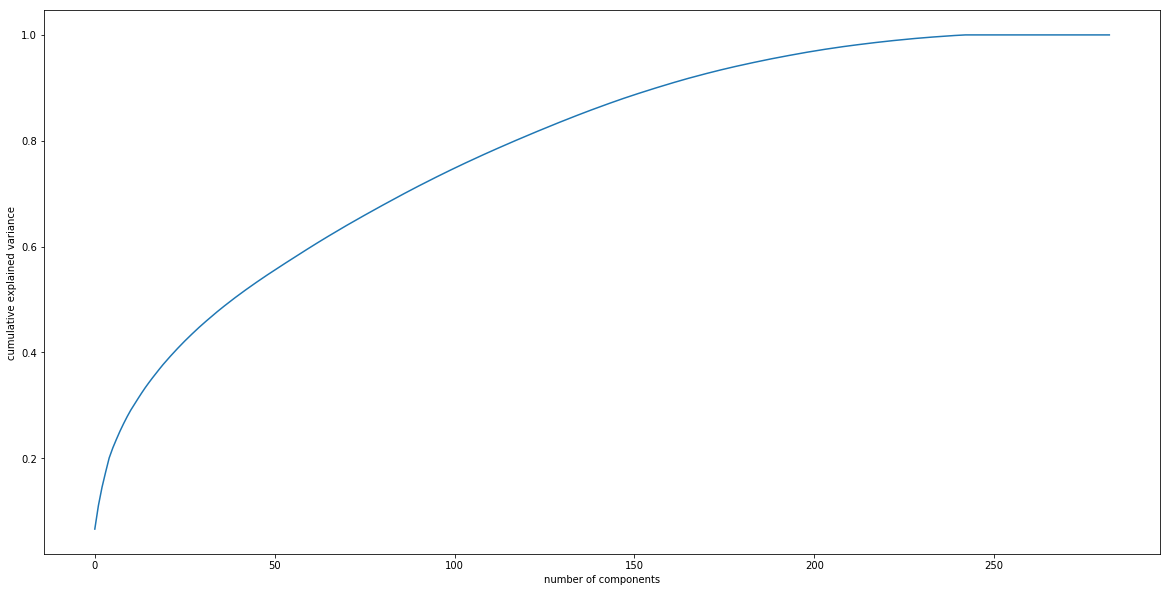

In [52]:
pca = PCA().fit(azdias)
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [53]:

def print_weights(n):
    '''
    n: number of principal component
    '''
    components = pd.DataFrame(np.round(pca.components_[n - 1: n], 4), columns = azdias.keys())
    components.index = ['Weights']
    components = components.sort_values(by = 'Weights', axis = 1, ascending=False)
    components = components.T
    print(components)
    return components

With PCA we hope to make our data has high variance. This way we do not lose critical information from dataset while reducing dimensions. Based on above chart we can see that at around 250 components, cumulative variance is still high. Let us reduce our data with 250 components

In [54]:
def reduce_data(df,n=250):
    pca = PCA(n_components=n).fit(df)
    reduced_data = pca.transform(df)
    reduced_data = pd.DataFrame(reduced_data)
    print(pca.explained_variance_ratio_.sum())
    return reduced_data

In [55]:
reduced_azdias = reduce_data(azdias)
reduced_customers = reduce_data(customers)

1.0
0.999866083281


In [58]:
print('number of rows in new dataset: ',reduced_azdias.shape)
print('number of rows in new dataset: ',reduced_customers.shape)

number of rows in new dataset:  (415405, 250)
number of rows in new dataset:  (100341, 250)


## Clustering

In [59]:
def score(data, k):
    kmeans_k = KMeans(k)
    model_k = kmeans_k.fit(data)
    return abs(model_k.score(data))

In [60]:
centers = np.linspace(1,21,21)
centers

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.])

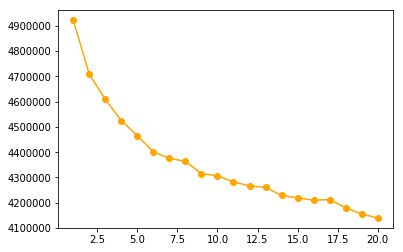

In [61]:
scores = []
for i in range(1, 21):
    scores.append(score(reduced_azdias.sample(20000), i))
centers = np.linspace(1,20,20)
plt.plot(centers, scores, linestyle='-', marker='o', color='orange')

Text(0.5,0,'Number of Clusters')

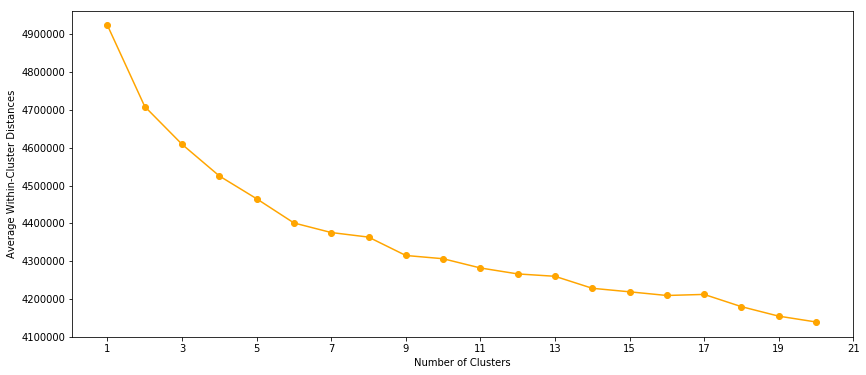

In [62]:
centers = np.linspace(1,20,20)
plt.figure(figsize=(14,6))
plt.plot(centers, scores, linestyle='-', marker='o', color='orange')
plt.xticks(list(range(1,22,2)))
plt.ylabel('Average Within-Cluster Distances')
plt.xlabel('Number of Clusters')

In [63]:
kmeans_k = KMeans(12)
model_k = kmeans_k.fit(reduced_azdias)
prediction_azdias = model_k.predict(reduced_azdias)

In [70]:

azdias_clustered = pd.DataFrame(prediction_azdias, columns = ['Cluster'])


In [71]:
prediction_customers = model_k.predict(reduced_customers)
customers_clustered = pd.DataFrame(prediction_customers, columns = ['Cluster'])


Analysis of data in clusters and also comparison between clusters of general population and customer data

In [72]:
# Count number of predictions for each customer segment# Count n 
customer_clusters = pd.Series(prediction_customers)
cc = customer_clusters.value_counts().sort_index()
# Count number in each population segment
population_clusters = pd.Series(prediction_azdias)
pc = population_clusters.value_counts().sort_index()

In [73]:
df_stat = pd.concat([pc, cc], axis=1).reset_index()
df_stat.columns = ['cluster','population','customer']

df_stat['difference'] = (df_stat['customer']/df_stat['customer'].sum()*100) - (df_stat['population']/df_stat['population'].sum()*100)
df_stat

,cluster,population,customer,difference
0,0,49048,432,-11.376741
1,1,12503,4721,1.695122
2,2,42334,2682,-7.518133
3,3,34547,688,-7.630800
4,4,31155,46418,38.760343
5,5,52491,32,-12.604211
6,6,15429,27,-3.687298
7,7,37209,21805,12.773615
8,8,34399,170,-8.111412
9,9,43613,12619,2.077205


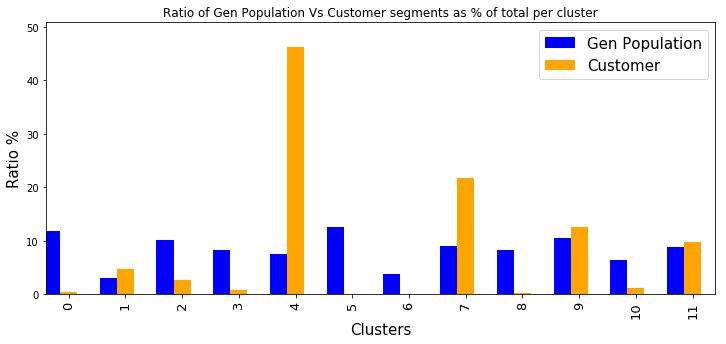

In [74]:
df_stat['pop_percent'] = (df_stat['population']/df_stat['population'].sum()*100).round(2)
df_stat['cust_percent'] = (df_stat['customer']/df_stat['customer'].sum()*100).round(2)


fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(111)
ax = df_stat['pop_percent'].plot(x=df_stat['cluster'],width=-0.3,align='edge',color='blue',kind='bar',position=0)
ax = df_stat['cust_percent'].plot(kind='bar',color='orange',width = 0.3, align='edge',position=1)
ax.set_xlabel('Clusters', fontsize=15) 
ax.set_ylabel('Ratio %', fontsize=15)
ax.xaxis.set(ticklabels=range(20))
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.margins(x=0.5,y=0.1)

plt.legend(('Gen Population', 'Customer'),fontsize=15)
plt.title(('Ratio of Gen Population Vs Customer segments as % of total per cluster'))
plt.show()

In [75]:
def pca_weights(pc,weight_num):
    
    ratio = pd.DataFrame(pca.explained_variance_ratio_,columns = ['EXPLAINED_VARIANCE'])
    ratio = ratio.round(3)
    weights = pd.DataFrame(pca.components_, columns = azdias.columns.values)
    weights = weights.round(3)    
    
    result = pd.concat([ratio, weights], axis = 1,  join_axes=[ratio.index])
    result[:5]
    print("Principal Component: ", (pc))    
    print('\n')
    print("Highest Positive weights:")
    print(result.iloc[(pc)-1].sort_values(ascending=False)[:weight_num])
    print('\n')
    print("Negative weights:")
    print(result.iloc[(pc)-1].sort_values()[:weight_num])

In [76]:

# Show highest positive and negative weights for 5 cluster (over representation of Customer)
pca_weights(5,5)

Principal Component:  5


Highest Positive weights:
KBA13_KMH_210          0.223
OST_WEST_KZ_O          0.187
KBA13_CCM_1401_2500    0.183
KBA13_VORB_0           0.135
KBA13_CCM_2000         0.134
Name: 4, dtype: float64


Negative weights:
KBA13_KW_0_60         -0.239
KBA13_KMH_180         -0.196
KBA13_CCM_0_1400      -0.194
OST_WEST_KZ_W         -0.187
KBA13_SEG_MINIWAGEN   -0.159
Name: 4, dtype: float64


In [77]:

# Show lowest positive and negative weights for 10 cluster (under representation of Customer)
pca_weights(10,5)

Principal Component:  10


Highest Positive weights:
KBA05_MAXSEG     0.272
KBA05_KRSOBER    0.208
KBA05_CCM3       0.186
KBA05_HERST1     0.165
KBA05_KW2        0.163
Name: 9, dtype: float64


Negative weights:
KBA05_CCM1        -0.235
KBA05_MODTEMP     -0.210
KBA05_HERST3      -0.162
OST_WEST_KZ_W     -0.148
KBA05_HERSTTEMP   -0.137
Name: 9, dtype: float64


In [81]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Analysis of principal components of cluster 2 with over-representation in customer segment.
CC = model_k.cluster_centers_[2]
CC = pd.Series(CC)
CC.index = CC.index +1
print(CC.sort_values(ascending=False).head(5))

# Transform cluster 2 to original feature values.
# CC_inv = scale.inverse_transform(pca.inverse_transform(CC))
# CC_inv = pd.Series(CC_inv).round(2)
# CC_inv.index = azdias_subset_columns
# CC_inv

3     2.335757
8     0.612227
7     0.534807
11    0.274141
32    0.178484
dtype: float64


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [82]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [83]:

X = mailout_train.drop('RESPONSE',axis=1)
y = mailout_train['RESPONSE']

In [84]:
df_mailout_train  = clean_data(X, False)

shape after corr (42962, 253)
shape after one-hot (42962, 300)
shape after impute (42962, 300)
shape after scaling (42962, 300)


In [85]:
df_mailout_train.shape

(42962, 299)

In [86]:
y.shape

(42962,)

In [87]:
df_mailout_train.head(5)

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_3,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_OFFLINE_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,...,KBA13_SEG_KLEINST,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_WOHNMOBILE,KBA13_SITZE_4,KBA13_SITZE_6,KBA13_TOYOTA,KBA13_VORB_0,KBA13_VORB_1_2,KBA13_VORB_3,KKK,KONSUMNAEHE,MIN_GEBAEUDEJAHR,MOBI_RASTER,ONLINE_AFFINITAET,PRAEGENDE_JUGENDJAHRE,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_SOZ,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,CAMEO_DEU_2015_-1,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX,OST_WEST_KZ_-1,OST_WEST_KZ_O,OST_WEST_KZ_W
LNR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-1.656309,1.031262,-0.545883,-0.371726,-0.428455,0.573402,-0.499090,-0.204857,-0.752038,-0.083831,-0.459891,0.203551,0.355905,0.400669,-0.732206,0.756779,-0.396140,0.563449,0.580973,-0.224018,-0.386557,-0.311376,-0.131465,0.180465,-0.265409,-0.420594,-0.628321,-0.455670,-0.339433,-0.890460,-0.195661,-0.384801,-0.296902,-0.357622,-0.277236,-0.670418,0.332665,-0.614365,-0.656230,-0.499065,-0.506860,1.607224,-0.370249,-0.732580,-0.328887,-0.441823,-0.705592,-0.578366,-0.352762,-1.250845,-0.260739,-0.816325,-0.196130,-0.421768,0.246638,0.084154,-0.030245,-0.351388,-0.216292,-0.399678,-0.267718,0.159771,0.060848,2.183981,1.09062,-0.396608,0.495253,1.059610,0.454064,1.385118,-0.681520,1.036622,-1.638766,0.317880,-1.207588,0.481833,-0.

In [88]:

X_train, X_val, y_train, y_val = train_test_split(df_mailout_train, y, stratify=y, test_size=0.2, random_state=42)

In [112]:
! pip install --upgrade setuptools
! pip install --upgrade pip
! pip install xgboost

    100% |████████████████████████████████| 788kB 8.7MB/s eta 0:00:01    46% |███████████████                 | 368kB 9.8MB/s eta 0:00:01
  Found existing installation: setuptools 38.4.0
    Uninstalling setuptools-38.4.0:
      Successfully uninstalled setuptools-38.4.0
    100% |████████████████████████████████| 1.5MB 9.3MB/s eta 0:00:01 5% |█▊                              | 81kB 3.4MB/s eta 0:00:01    36% |███████████▊                    | 552kB 8.3MB/s eta 0:00:01
  Found existing installation: pip 18.1
    Uninstalling pip-18.1:
      Successfully uninstalled pip-18.1
     |████████████████████████████████| 148.9 MB 14 kB/s s eta 0:00:01  |▏                               | 675 kB 3.2 MB/s eta 0:00:46     |▌                               | 2.3 MB 3.2 MB/s eta 0:00:46     |▊                               | 3.3 MB 3.2 MB/s eta 0:00:45     |█                               | 4.6 MB 3.2 MB/s eta 0:00:45     |██▏                             | 10.0 MB 3.2 MB/s eta 0:00:43     |████       

In [113]:
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor # Adaptive Boosting
from sklearn.ensemble import GradientBoostingRegressor # Gradient Tree Boosting
from xgboost.sklearn import XGBRegressor # Extreme Gradient Boosting


In [115]:

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)

[02:14:54] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[02:14:56] WARNING: ../src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=10, n_jobs=0, num_parallel_tree=1,
       objective='reg:linear', random_state=0, reg_alpha=10, reg_lambda=1,
       scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [116]:

preds = xg_reg.predict(X_val)

In [117]:
preds

array([ 0.18259767,  0.18259767,  0.18259767, ...,  0.18259767,
        0.18259767,  0.18259767], dtype=float32)

In [118]:

print("ROC score on validation data: {:.4f}".format(roc_auc_score(y_val, preds)))

ROC score on validation data: 0.5000


## Model Evaluation and Validation

In terms of evaluation metric to use, I have tried accuracy, precision, recall and fscore but due to very high imbalance (i.e. In MAILOUT_TRAIN dataset, we can find among 43000 individuals, only 532 people response to the mail-out campaign which means the training data is highly imbalanced.), none of these were a good way to measure and then finalised on AUC and ROC as the evaluation metric to proceed.

In [119]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train, y_train)
    end = time() # Get end time
    
           
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    roc = roc_auc_score(y_test, predictions_test)
        
    # Return the results
    return roc

In [120]:
skf = StratifiedKFold(n_splits=5, random_state=42)
skf.get_n_splits(X, y)

5

# Model evaluations and validation

In [124]:
alg_abr = AdaBoostRegressor(random_state=42)
alg_gbr = GradientBoostingRegressor(random_state=42)
alg_xgb = XGBRegressor(random_state=42)


result_list = []
for alg in [alg_abr, alg_gbr, alg_xgb]:
    alg_name = alg.__class__.__name__
    
    
    
    j=0
    for train_index, val_index in skf.split(df_mailout_train, y):
    
        j+=1
        #print('Fold {}...'.format(j))
        result = {}  
        result['alg_name'] = alg_name
        result['fold']  =  j
        # Split the data into training and test sets
        X_train, X_val = df_mailout_train.iloc[train_index], df_mailout_train.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        
        
        result['roc'] = train_predict(alg, X_train, y_train, X_val, y_val)
        result_list.append(result)
        print (result)
    
#return result_list    

print('result_list: ', result_list)

{'alg_name': 'AdaBoostRegressor', 'fold': 1, 'roc': 0.7520605681485284}
{'alg_name': 'AdaBoostRegressor', 'fold': 2, 'roc': 0.76112332351690848}
{'alg_name': 'AdaBoostRegressor', 'fold': 3, 'roc': 0.78820888122056743}
{'alg_name': 'AdaBoostRegressor', 'fold': 4, 'roc': 0.72870910578577819}
{'alg_name': 'AdaBoostRegressor', 'fold': 5, 'roc': 0.73072796926347061}
{'alg_name': 'GradientBoostingRegressor', 'fold': 1, 'roc': 0.73311512529708089}
{'alg_name': 'GradientBoostingRegressor', 'fold': 2, 'roc': 0.75193446710469802}
{'alg_name': 'GradientBoostingRegressor', 'fold': 3, 'roc': 0.80506516837943964}
{'alg_name': 'GradientBoostingRegressor', 'fold': 4, 'roc': 0.73210648837819448}
{'alg_name': 'GradientBoostingRegressor', 'fold': 5, 'roc': 0.75577588391979689}
{'alg_name': 'XGBRegressor', 'fold': 1, 'roc': 0.5558291721824401}
{'alg_name': 'XGBRegressor', 'fold': 2, 'roc': 0.60636375250274777}
{'alg_name': 'XGBRegressor', 'fold': 3, 'roc': 0.65723789237767871}
{'alg_name': 'XGBRegressor',

In [126]:
df_scores = pd.DataFrame(result_list)

In [127]:
df_scores

,alg_name,fold,roc
0,AdaBoostRegressor,1,0.752061
1,AdaBoostRegressor,2,0.761123
2,AdaBoostRegressor,3,0.788209
3,AdaBoostRegressor,4,0.728709
4,AdaBoostRegressor,5,0.730728
5,GradientBoostingRegressor,1,0.733115
6,GradientBoostingRegressor,2,0.751934
7,GradientBoostingRegressor,3,0.805065
8,GradientBoostingRegressor,4,0.732106
9,GradientBoostingRegressor,5,0.755776


## Algorithm score comparison

In [128]:
df_scores.groupby('alg_name')['roc'].mean()

alg_name
AdaBoostRegressor            0.752166
GradientBoostingRegressor    0.755599
XGBRegressor                 0.605846
Name: roc, dtype: float64

# Fine tuning

### Now we need to test and finalise the hyperparameters best suited for our project. Using GridSearchCV to finalise on hyper parameters to use.¶


In [137]:
parameters = { 'learning_rate' : [0.1],
                'n_estimators' :[500],
                'reg_alpha' : [0.05],
                'subsample' : [0.6],
                'colsample_bytree' : [0.7],
                'gamma' : [0.2],
                'max_depth' : [3],
                'min_child_weight' : [2],
                'objective' : ['binary:logistic'],
                'scale_pos_weight' : [1],
                'random_state' : [42],
                'scoring' : ['roc_auc']
             }

# Perform grid search on the classifier using 'scorer' as the scoring method
cv = GridSearchCV(alg_xgb, parameters, scoring = 'roc_auc', n_jobs= -1, cv=None)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = cv.fit(X_train, y_train)

cv.grid_scores_, cv.best_params_, cv.best_score_

# Get the estimator and predict
best_clf = grid_fit.best_estimator_
#predictions = (best_clf.fit(X_train, y_train)).predict(X_test)

best_predictions = best_clf.predict(X_val)

[02:59:10] WARNING: ../src/learner.cc:516: 
Parameters: { scoring } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:00:33] WARNING: ../src/learner.cc:516: 
Parameters: { scoring } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:01:55] WARNING: ../src/learner.cc:516: 
Parameters: { scoring } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:03:18] WARNING:

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [139]:
roc_auc_score(y_val, best_predictions)

0.72427283116698316

### More hyper Parameter testing

In [140]:
alg_test = XGBRegressor(
    learning_rate = 0.1,
    n_estimators = 500,
    reg_alpha = 0.05,
    subsample = 0.6,
    colsample_bytree = 0.7,
    gamma = 0.2,
    max_depth = 3,
    min_child_weight = 2,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    random_state = 42,
    scoring = 'roc_auc')

In [141]:
cv = StratifiedKFold(n_splits=2,shuffle=True, random_state=42)

roc_score = []
for train,test in cv.split(X_train,y_train):
    preds = alg_test.fit(X_train,y_train)
    predictions_test = preds.predict(X_val)
    roc_score.append(roc_auc_score(y_val, predictions_test))
    
print(roc_score)

[03:08:05] WARNING: ../src/learner.cc:516: 
Parameters: { scoring } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[03:10:08] WARNING: ../src/learner.cc:516: 
Parameters: { scoring } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0.72427283116698316, 0.72427283116698316]


# Final Model for scoring

In [142]:
clf_final = xgb.XGBRegressor(
    objective = 'binary:logistic',
    max_depth = 5,
    min_child_weight = 2,
    learning_rate = 0.01,    
    reg_alpha = 0.05,
    subsample = 0.6,
    colsample_bytree = 0.7,
    gamma = 0.2,    
    scale_pos_weight = 1,
    random_state = 42,
    n_estimators = 500,
    scoring = 'roc_auc')

preds = clf_final.fit(X_train,y_train)
predictions_test = preds.predict(X_val)
print(roc_auc_score(y_val, predictions_test))

[03:12:12] WARNING: ../src/learner.cc:516: 
Parameters: { scoring } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


0.775990643857


## Identify and understand important features from supervised learning

In [143]:
feat_importance = clf_final.feature_importances_
feat_importance

array([ 0.00341953,  0.00324988,  0.00323133,  0.00377345,  0.00392225,
        0.00304779,  0.00158646,  0.00416888,  0.00240903,  0.00269469,
        0.00654597,  0.00326623,  0.00281847,  0.00285094,  0.00263035,
        0.00199622,  0.00212646,  0.00206379,  0.0019592 ,  0.00375027,
        0.00461571,  0.        ,  0.00482907,  0.00309237,  0.0017093 ,
        0.00265192,  0.00520303,  0.00135119,  0.00440843,  0.00102132,
        0.00657626,  0.00163337,  0.00309451,  0.00012241,  0.0047506 ,
        0.00450654,  0.00204041,  0.00295128,  0.00405032,  0.00377026,
        0.00412515,  0.00865746,  0.00508435,  0.00182782,  0.00408437,
        0.00490427,  0.00457868,  0.00409925,  0.00423773,  0.01315489,
        0.00447   ,  0.00166009,  0.00391318,  0.00410942,  0.00065127,
        0.        ,  0.00485176,  0.        ,  0.00266712,  0.00607258,
        0.        ,  0.00144846,  0.00274731,  0.00383783,  0.00251395,
        0.        ,  0.00400201,  0.00565246,  0.0043189 ,  0.00

['D19_SOZIALES' 'D19_LEBENSMITTEL' 'OST_WEST_KZ_W' 'KBA05_SEG8'
 'D19_DROGERIEARTIKEL']
[ 0.01315489  0.00865746  0.00738583  0.00720228  0.00657626]


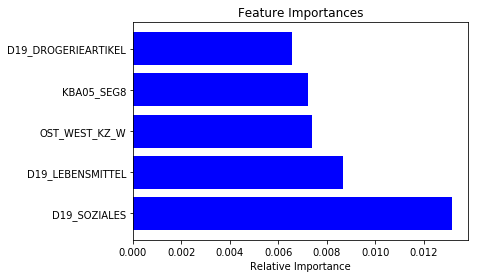

In [144]:
num_feat = 5

indices = np.argsort(feat_importance)[::-1]
columns = X_train.columns.values[indices[:num_feat]]
values = feat_importance[indices][:num_feat]

#print((indices))
print(columns)
print(values)

plt.title('Feature Importances')
plt.barh(np.arange(num_feat), values, color='b', align='center', label = "Feature Weight")
#plt.barh(np.arange(num_feat), np.cumsum(values), color='b', align='center',label = "Cumsum Weight")


plt.yticks(np.arange(num_feat), columns)
plt.xlabel('Relative Importance')
plt.show()


In [145]:
mailout_train['D19_SOZIALES'].unique()

array([  1.,   5.,   2.,   3.,   4.,  nan,   0.])

# Analyzing most important feature

In [163]:
# earlier fit of data was done within method so it could not be used now for inverse_transform.
# as we have actual cleaned customer data, lets quickly do pca.

customers_pca = PCA(n_components=220).fit(customers)
customers_pca_data = customers_pca.transform(customers)

In [168]:
customers_pca_data

array([[ -8.18160423e+00,   6.94114706e-01,   1.67799304e+00, ...,
         -4.58077121e-03,   9.28910118e-04,   5.52424621e-04],
       [  9.03365685e+00,   8.16309371e-01,  -1.45887362e+00, ...,
         -1.18335450e-01,  -2.15789473e-01,  -1.45282181e-01],
       [  1.02588384e+01,  -6.33592216e+00,   9.55380607e-01, ...,
         -1.14467685e-01,   3.15975753e-01,  -1.18711624e-01],
       ..., 
       [ -6.69294535e-01,   5.22381656e+00,   3.97569416e+00, ...,
          2.86736285e-02,  -2.83283601e-01,   5.20231464e-01],
       [  1.11522409e+01,  -6.60177344e-01,   3.91841806e+00, ...,
         -7.79590402e-02,  -2.58516469e-01,   1.88445333e-01],
       [  9.72658513e+00,  -1.38633375e+00,   4.50668744e-01, ...,
         -2.29736309e-01,  -5.27456865e-01,  -2.90328234e-01]])

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [171]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [172]:
# as we want to make prediction using model trained with mailout_train, check/make sure this dataset is not different
missing = list(np.setdiff1d(mailout_train.columns, mailout_test.columns))
missing

['RESPONSE']

In [176]:
print('before preprocessing mailout_test.shape: ', mailout_test.shape)
mailout_test_clean = clean_data(mailout_test, False)
print('after preprocessing mailout_test_clean.shape: ', mailout_test_clean.shape)

before preprocessing mailout_test.shape:  (42833, 366)
shape after corr (42833, 253)
shape after one-hot (42833, 300)
shape after impute (42833, 300)
shape after scaling (42833, 300)
after preprocessing mailout_test_clean.shape:  (42833, 299)


In [177]:
prediction_for_kaggle = clf_final.predict(mailout_test_clean)

In [178]:
df_kaggle = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=prediction_for_kaggle)
df_kaggle.rename(columns={0: "RESPONSE"}, inplace=True)

In [179]:

df_kaggle.to_csv('submission.csv')

OSError: [Errno 28] No space left on device